(891, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


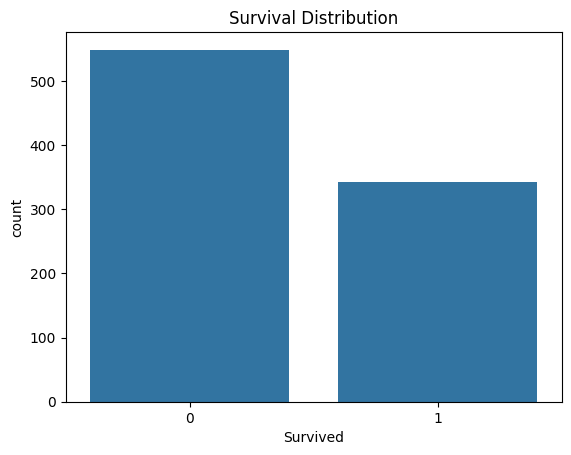

<Axes: xlabel='Sex', ylabel='Survived'>

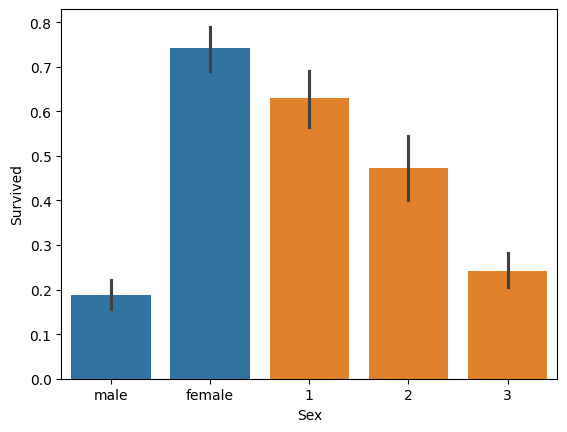

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
train_df = pd.read_csv("../data/raw/train.csv")
test_df = pd.read_csv("../data/raw/test.csv")

# Overview
print(train_df.shape)
train_df.head()

# Info
train_df.info()
train_df.describe()

# Check missing values
train_df.isnull().sum()

# Visualize target balance
sns.countplot(x='Survived', data=train_df)
plt.title("Survival Distribution")
plt.show()

# Check relationships
sns.barplot(x='Sex', y='Survived', data=train_df)
sns.barplot(x='Pclass', y='Survived', data=train_df)


***data processing***

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path

RAW_DIR = Path("../data/raw")
PROC_DIR = Path("../data/processed")
PROC_DIR.mkdir(parents=True, exist_ok=True)

# --- 1) Load fresh copies from RAW so re-runs are always clean ---
train_df = pd.read_csv(RAW_DIR / "train.csv")
test_df  = pd.read_csv(RAW_DIR / "test.csv")

# Keep originals intact
train_df = train_df.copy()
test_df  = test_df.copy()

# --- 2) Impute missing values (deterministic, no leakage) ---
# Use train statistics for both train/test where sensible
age_median   = train_df["Age"].median()
fare_median  = train_df["Fare"].median() if "Fare" in train_df else test_df["Fare"].median()
embark_mode  = train_df["Embarked"].mode(dropna=True)[0]

# Age
train_df.loc[:, "Age"] = train_df["Age"].fillna(age_median)
test_df.loc[:,  "Age"] = test_df["Age"].fillna(age_median)

# Fare (train sometimes complete; test has NaNs)
if "Fare" in train_df.columns:
    train_df.loc[:, "Fare"] = train_df["Fare"].fillna(fare_median)
test_df.loc[:, "Fare"] = test_df["Fare"].fillna(fare_median)

# Embarked
train_df.loc[:, "Embarked"] = train_df["Embarked"].fillna(embark_mode)
test_df.loc[:,  "Embarked"] = test_df["Embarked"].fillna(embark_mode)

# --- 3) Encode categoricals (idempotent & aligned) ---
# Sex → {male:0, female:1}
sex_map = {"male": 0, "female": 1}
for df in (train_df, test_df):
    # if already numeric, leave it; else map safely
    if df["Sex"].dtype == "object":
        df.loc[:, "Sex"] = (
            df["Sex"].astype(str).str.strip().str.lower().map(sex_map).astype("Int64")
        )
    else:
        df.loc[:, "Sex"] = df["Sex"].astype("Int64")

# Embarked → integer codes with stable categories across train+test
all_embarked = pd.Categorical(
    pd.concat([train_df["Embarked"], test_df["Embarked"]], ignore_index=True)
)
cats = list(all_embarked.categories)  # discovered categories
train_df.loc[:, "Embarked"] = pd.Categorical(train_df["Embarked"], categories=cats).codes
test_df.loc[:,  "Embarked"] = pd.Categorical(test_df["Embarked"],  categories=cats).codes

# --- 4) Simple feature engineering ---
for df in (train_df, test_df):
    df.loc[:, "FamilySize"] = df["SibSp"] + df["Parch"] + 1
    df.loc[:, "IsAlone"]    = (df["FamilySize"] == 1).astype("Int64")

# --- 5) Drop high-cardinality / mostly-missing columns (safe) ---
drop_cols = ["Name", "Ticket", "Cabin"]
train_df = train_df.drop(columns=[c for c in drop_cols if c in train_df.columns], errors="ignore")
test_df  = test_df.drop(columns=[c for c in drop_cols if c in test_df.columns], errors="ignore")

# --- 6) Save processed outputs ---
train_df.to_csv(PROC_DIR / "train_processed.csv", index=False)
test_df.to_csv(PROC_DIR / "test_processed.csv", index=False)

print("✅ Preprocessing complete.")
print("Train shape:", train_df.shape, "| Test shape:", test_df.shape)
print("Processed files written to:", PROC_DIR.resolve())


✅ Preprocessing complete.
Train shape: (891, 11) | Test shape: (418, 10)
Processed files written to: C:\Users\nicho\Documents\Kaggle\titanic\data\processed
